# Stick Barrette

> A hair clip made up of two parts

| Main (top/outer) part | Stick (bottom/inner) part |
| --- | --- |
| <a title="Auckland Museum, CC BY 4.0 &lt;https://creativecommons.org/licenses/by/4.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Hair_slide_(AM_1993.1-3).jpg"><img width="256" alt="Hair slide (AM 1993.1-3)" src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Hair_slide_%28AM_1993.1-3%29.jpg/512px-Hair_slide_%28AM_1993.1-3%29.jpg?20191031040432"></a> | <a title="Auckland Museum, CC BY 4.0 &lt;https://creativecommons.org/licenses/by/4.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Hair_slide_(AM_1993.1-4).jpg"><img width="256" alt="Hair slide (AM 1993.1-4)" src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/35/Hair_slide_%28AM_1993.1-4%29.jpg/512px-Hair_slide_%28AM_1993.1-4%29.jpg?20191031040453"></a> |

Lets design this part. As opposed to other hair clips, there is no need for complex spring mechanism,
and the whole thing can be 3d printed without any supports.

In [ ]:
#| default_exp scad.helpers.arc

In [ ]:
#| export
from cadlab.scad import *
from solid2 import *
from math import pi, cos, sin
from fastcore.all import *
from cmath import exp
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
set_global_fn(100)

Length of the outer part.

In [ ]:
outer_length = 120

Now we need the radius of circumference. [This](https://en.wikipedia.org/wiki/Occipital_bone) is the part of the human skull we are interested in. The radius of circumference varies from person to person, but is about 9 cm according to Llama 3.3 70B, and that sounds about right, so I am gonna trust it for now.

In [ ]:
outer_radius = 90

Note that we could make an arc by subtracting a section from a circle, but this won't work for angles larger than 180 degrees. So let's just use a polygon.

In [ ]:
#| export
def arc_2d(r, start_angle, end_angle, thickness, step=0.5):
    angles = np.arange(np.deg2rad(start_angle), np.deg2rad(end_angle)+np.deg2rad(step), np.deg2rad(step))
    unit_points = np.stack([np.cos(angles), np.sin(angles)],axis=1)
    points = np.concat([r*unit_points, (r-thickness)*np.flip(unit_points, axis=0)])
    
    return polygon(points)

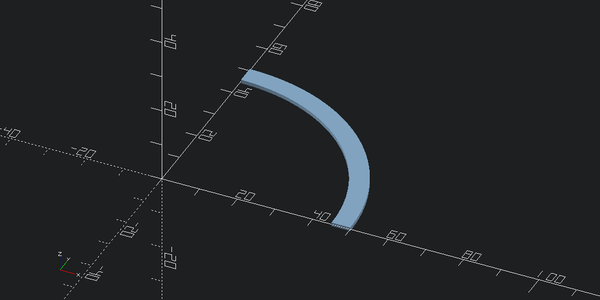

In [ ]:
r = 50
thickness = 5

start_angle = 0
end_angle = 90
arc_2d(r, start_angle, end_angle, thickness)

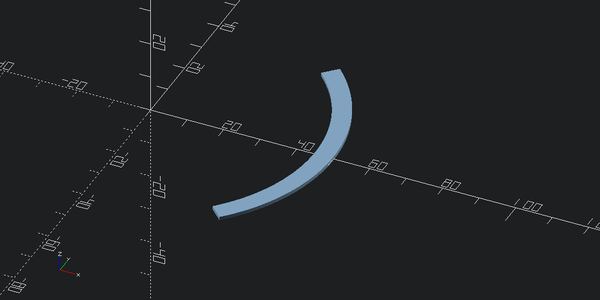

In [ ]:
arc_2d(r, -45, 45, thickness)

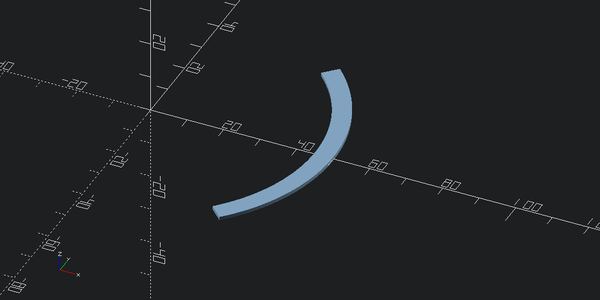

In [ ]:
arc_2d(r, -45, 45, thickness)

In [ ]:
@delegates(arc_2d)
def arc_3d(r, start_angle, end_angle, thickness, height, **kwargs):
    return (arc_2d(r, start_angle, end_angle, thickness, **kwargs)).linear_extrude(height)

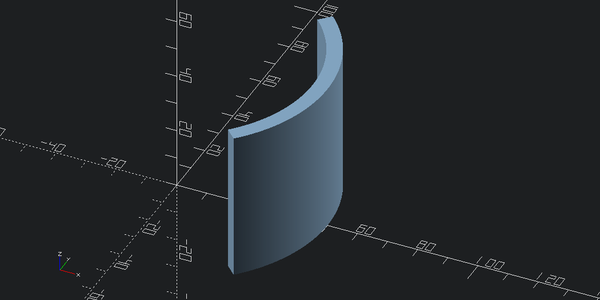

In [ ]:
arc_3d(r, -45, 45, thickness, 50)

In [ ]:
outer_height = 40

In [ ]:
outer_angle = outer_length / outer_radius
outer_angle = np.rad2deg(outer_angle)
outer_angle

np.float64(76.39437268410975)

In [ ]:
outer_thickness = 5

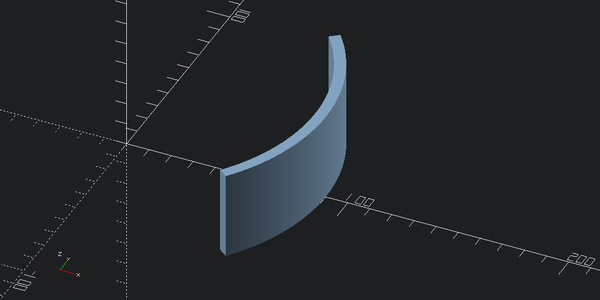

In [ ]:
outer_part = arc_3d(outer_radius, -outer_angle/2, outer_angle/2, outer_thickness, outer_height)
outer_part

Cool, now lets add holes where inner part would go.
To make it compatible with 3d printing, lets make holes using a 45 degree rotated
cube so that we only have 45 degree inclines maximum.

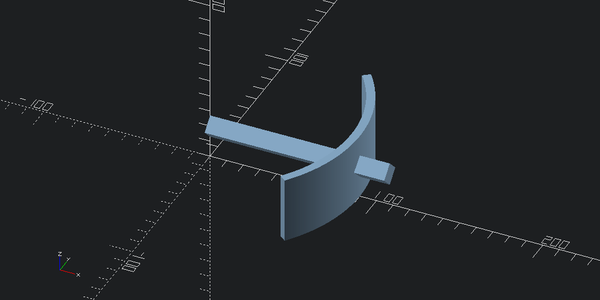

In [ ]:
r = outer_radius*1.2
hole_size = 10

hole_cutter = (cube([r,hole_size,hole_size])
               .translate([0,-hole_size/2,-hole_size/2])
               .rotate([45,0,0])
               .translate([0,0,outer_height/2]))

outer_part + hole_cutter

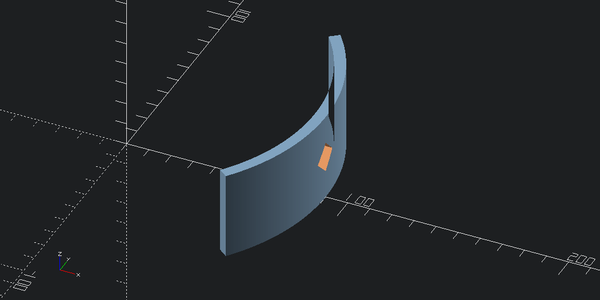

In [ ]:
outer_part - hole_cutter

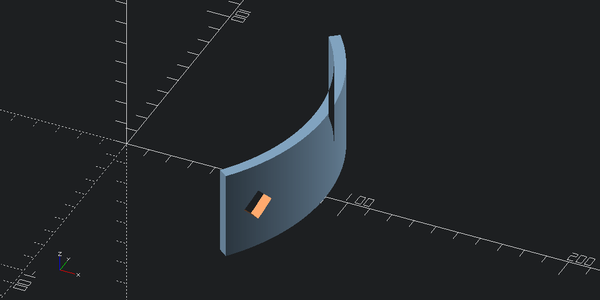

In [ ]:
hole_inset_angle = 10
outer_part - hole_cutter.rotate([0,0,-(outer_angle/2-hole_inset_angle)])

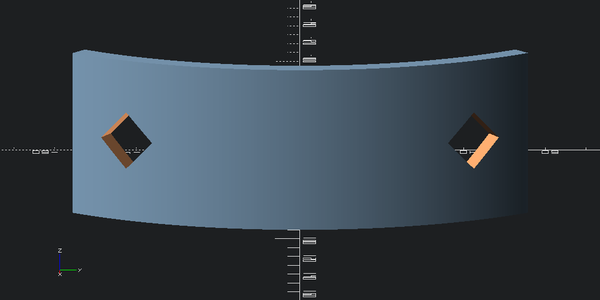

In [ ]:
outer_with_holes = (outer_part
                    -hole_cutter.rotate([0,0,-(outer_angle/2-hole_inset_angle)])
                    -hole_cutter.rotate([0,0,(outer_angle/2-hole_inset_angle)]))

view(outer_with_holes, eye=(outer_radius*2,0,outer_height), viewall=False)

These holes look cool, so let's make a repeating pattern.

For 3d printing, using more holes would also speed up the printing time and reduce material usage.

## Adding repeating pattern

Now we are back to the same problem we had when we needed to place teeth in the [gear](00_gear.ipynb) example.

We have a polygonal section of known radius and of known segment length and we want to relate that to angles.

Aside: turns out this problem has a nice application to wave [diffraction](https://www.feynmanlectures.caltech.edu/I_30.html).

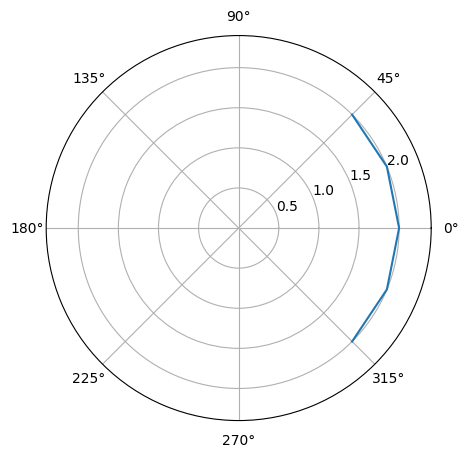

In [ ]:
n = 4+1
r = 2
rs = r*np.ones(n)
theta = np.linspace(-np.deg2rad(45),np.deg2rad(45),n)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5,5))
ax.plot(theta, rs)
ax.set_rmax(r*1.2)
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

Here we have a circle of radius 2 and a polyhedral segment where distance from origin to every vertex is equal to 2
and angle between each pair of consequent vertices is equal to 90/4 = 22.5 degrees.

In our other problem, on the other hand, we know segment length (it's diagonal of the cube plus any margin we need),
and we know the radius (it's outer_radius), and we want to know how much angular spacing is between each consequent pair
of vertices.

We have an equilateral triangle of known side and base and we want to find the height.
If we split base into two, we would end up with the right triangle.

Hence, the sine of the half angle is equal to the half base divided by the side.

Thus:

In [ ]:
#| export
def segment_angle(base, side, deg=True): return 2*np.asin(base/2 / side) * (180/np.pi if deg else 1)

In [ ]:
test_eq(segment_angle(0,10), 0)

$$\text{hole\_diam}^2 + \text{hole\_diam}^2 = \text{hole\_size}^2$$

In [ ]:
hole_diam = hole_size/np.sqrt(2)
hole_diam

np.float64(7.071067811865475)

In [ ]:
margin = 10

In [ ]:
hole_side = hole_diam + margin

In [ ]:
sa = segment_angle(hole_side, outer_radius)
sa

np.float64(10.884137282582449)

Well, let's test it out

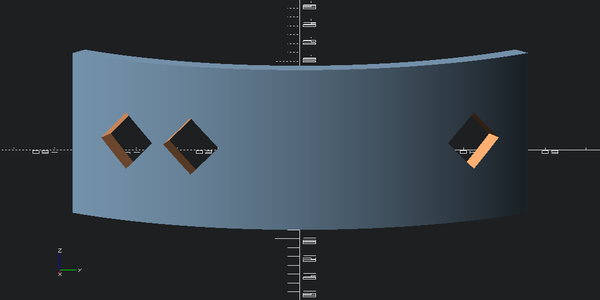

In [ ]:
outer_with_holes = (outer_part
                    -hole_cutter.rotate([0,0,-(outer_angle/2-hole_inset_angle)])
                    -hole_cutter.rotate([0,0,-(outer_angle/2-hole_inset_angle-sa)])
                    -hole_cutter.rotate([0,0,(outer_angle/2-hole_inset_angle)]))

view(outer_with_holes, eye=(outer_radius*2,0,outer_height), viewall=False)

Looks good.

Now, how many holes can we fit in total?

In [ ]:
outer_angle / sa

np.float64(7.018872575813733)

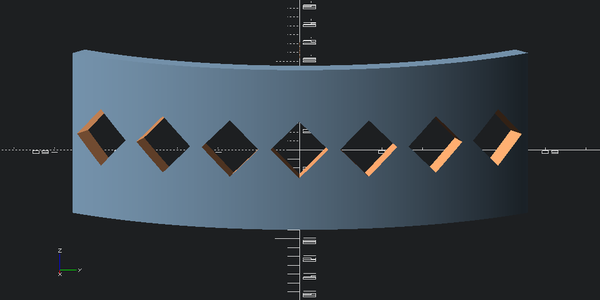

In [ ]:
outer_with_holes = outer_part

for i in range(7):
    outer_with_holes -= hole_cutter.rotate([0,0,-(outer_angle/2-i*sa - sa/2)])

view(outer_with_holes, eye=(outer_radius*2,0,outer_height), viewall=False)

Looks nice! Let's add more rows.

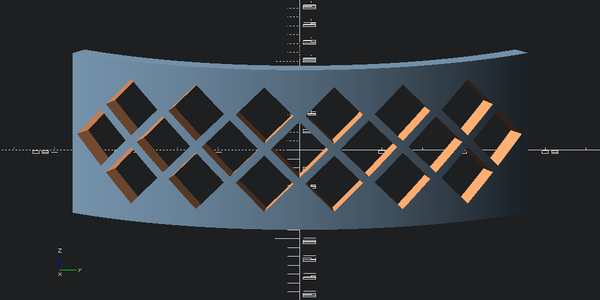

In [ ]:
outer_with_holes = outer_part

for i in range(7):
    outer_with_holes -= hole_cutter.rotate([0,0,-(outer_angle/2-i*sa - sa/2)])

for i in range(6):
    outer_with_holes -= hole_cutter.rotate([0,0,-(outer_angle/2-i*sa - sa)]).translate([0,0,hole_side/2])

for i in range(6):
    outer_with_holes -= hole_cutter.rotate([0,0,-(outer_angle/2-i*sa - sa)]).translate([0,0,-hole_side/2])

outer_with_holes_v1 = outer_with_holes

view(outer_with_holes, eye=(outer_radius*2,0,outer_height), viewall=False)

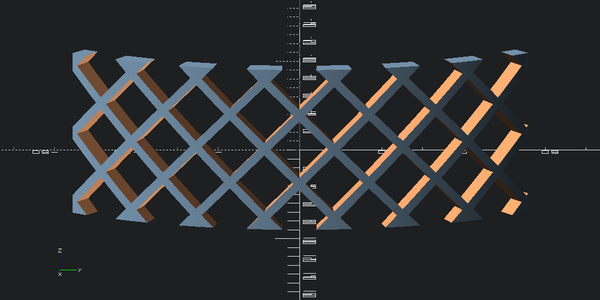

In [ ]:
outer_with_holes = outer_part

for i in range(7):
    outer_with_holes -= hole_cutter.rotate([0,0,-(outer_angle/2-i*sa - sa/2)])

for i in range(9):
    outer_with_holes -= hole_cutter.rotate([0,0,-(outer_angle/2-i*sa + sa)]).translate([0,0,hole_side/2])

for i in range(9):
    outer_with_holes -= hole_cutter.rotate([0,0,-(outer_angle/2-i*sa + sa)]).translate([0,0,-hole_side/2])

for i in range(7):
    outer_with_holes -= hole_cutter.rotate([0,0,-(outer_angle/2-i*sa - sa/2)]).translate([0,0,hole_side])

for i in range(7):
    outer_with_holes -= hole_cutter.rotate([0,0,-(outer_angle/2-i*sa - sa/2)]).translate([0,0,-hole_side])

view(outer_with_holes, eye=(outer_radius*2,0,outer_height), viewall=False)

I think I like the one with only three rows more:

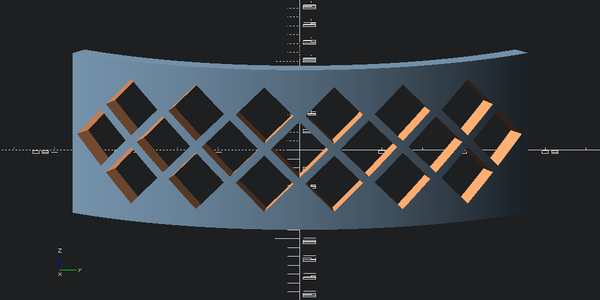

In [ ]:
outer_with_holes = outer_with_holes_v1

view(outer_with_holes, eye=(outer_radius*2,0,outer_height), viewall=False)

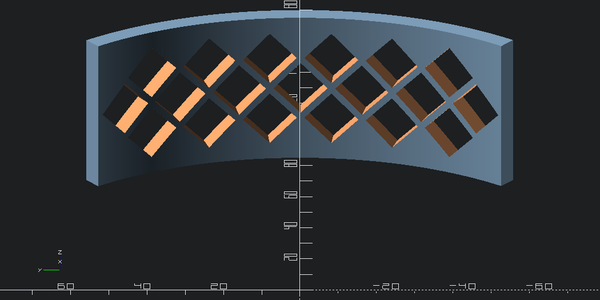

In [ ]:
view(outer_with_holes, eye=(-outer_radius,0,2*outer_height),center=(outer_radius,0,0), viewall=False)

Ok, let's 3d print this to check out how it look in real life.

In [ ]:
stl = export_to_stl(outer_with_holes)

In [ ]:
stl.save('barrette.stl')